# **Smart Factories - Pipeline Training and Inference**

In [ ]:
#!pip install pyspark xgboost
!pip install xgboost pyarrow

## Libraries and Spark + Class DataProcessor  Initializing

In [ ]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.window import Window
from pyspark.sql.functions import year, month, dayofmonth, hour, unix_timestamp, lag, expr, mean, log1p, col
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator

from xgboost.spark import SparkXGBRegressor

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

from spark_model_utility import DataProcessor, ModelEvaluator, assemblerAndPipeline, train_and_save_model

# Initialize Spark session
spark = SparkSession.builder.appName("ML_Training").getOrCreate()

# Class for Data Loading and Preprocessing
processor = DataProcessor(spark)

25/03/25 17:25:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Load Data

In [ ]:
## Load datasets
df_A = processor.load_data("company_A.csv")
df_B = processor.load_data("company_B.csv")

In [ ]:
# Show schema and first few rows
df_A.printSchema()
df_B.printSchema()

df_A.show(5)
df_B.show(5)


root
 |-- ts: timestamp (nullable = true)
 |-- asset: integer (nullable = true)
 |-- items: double (nullable = true)
 |-- status: double (nullable = true)
 |-- status_time: double (nullable = true)
 |-- power_avg: double (nullable = true)
 |-- cycle_time: double (nullable = true)
 |-- alarm: integer (nullable = true)

root
 |-- ts: timestamp (nullable = true)
 |-- asset: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- alarm_time: double (nullable = true)
 |-- loading_time: double (nullable = true)
 |-- tooling_time: double (nullable = true)
 |-- maintenance_time: double (nullable = true)
 |-- support_time: double (nullable = true)
 |-- power_avg: double (nullable = true)
 |-- power_min: double (nullable = true)
 |-- power_max: double (nullable = true)

+-------------------+-----+-----+------+-----------+---------+----------+-----+
|                 ts|asset|items|status|status_time|power_avg|cycle_time|alarm|
+-------------------+-----+-----+------+-----------+----

## Data Preprocessing

### Company B "Status" to Numerical

In [ ]:
# Convert categorical 'status' in df_B to numerical labels
indexer = StringIndexer(inputCol="status", outputCol="status_index")
df_B = indexer.fit(df_B).transform(df_B).drop("status")

df_B.show(5)

+-------------------+-----+----------+------------+------------+----------------+------------+------------------+----------+------------------+------------+
|                 ts|asset|alarm_time|loading_time|tooling_time|maintenance_time|support_time|         power_avg| power_min|         power_max|status_index|
+-------------------+-----+----------+------------+------------+----------------+------------+------------------+----------+------------------+------------+
|2021-11-16 17:47:00|   12|       0.0|         0.0|         0.0|             0.0|         0.0|1.1394553037383175| 1.0076175|           1.34349|         1.0|
|2021-11-16 17:47:00|    7|       0.0|         0.0|         0.0|             0.0|         0.0| 63.29952652777779|   6.71745|          95.38779|         0.0|
|2021-11-16 17:47:00|    9|       0.0|         0.0|         0.0|             0.0|         0.0|           148.968|   79.3801|           408.434|         0.0|
|2021-11-16 17:47:00|    6|       0.0|         0.0|       

### Time Features, Power average log transform and Lag Features

- Time Features - Time-series data, therefore time features essential to train time indexes
- Log Transform - Power spikes and outliers drastically affect the model training, so using log transform on the feature scales the values.
- Lag Features - Time series lags the target column for each model (`power_avg`,`items`, `status/status_index`) for forecasting purposes. The data is processed using a window partitioned by asset and ordered by time.

In [ ]:
#Apply time feature extraction
df_A = processor.extract_time_features(df_A).drop("ts")
df_B = processor.extract_time_features(df_B).drop("ts")

# Apply Log transform
df_A = processor.log_transform_column(df_A, "power_avg", output_col="log_power")
df_B = processor.log_transform_column(df_B, "power_avg", output_col="log_power")


# Apply lag features to both datasets
target_columns_A = ["log_power", "items", "status"]
target_columns_B = ["log_power", "status_index"]
df_A = processor.add_lag_features(df_A, "asset", "ts_unix", target_columns_A)
df_B = processor.add_lag_features(df_B, "asset", "ts_unix", target_columns_B)

# Show schema and first few rows
df_A.printSchema()
df_B.printSchema()

df_A.show(5)
df_B.show(5)

root
 |-- asset: integer (nullable = true)
 |-- items: double (nullable = true)
 |-- status: double (nullable = true)
 |-- status_time: double (nullable = true)
 |-- power_avg: double (nullable = true)
 |-- cycle_time: double (nullable = true)
 |-- alarm: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- ts_unix: long (nullable = true)
 |-- log_power: double (nullable = true)
 |-- log_power_lag1: double (nullable = false)
 |-- log_power_lag2: double (nullable = false)
 |-- log_power_lag3: double (nullable = false)
 |-- items_lag1: double (nullable = false)
 |-- items_lag2: double (nullable = false)
 |-- items_lag3: double (nullable = false)
 |-- status_lag1: double (nullable = false)
 |-- status_lag2: double (nullable = false)
 |-- status_lag3: double (nullable = false)

root
 |-- asset: integer (nullable = true)
 |-- alarm_time: double (nullable = true)
 |--

+-----+-----+------+-----------+---------+----------+-----+----+-----+---+----+----------+---------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|asset|items|status|status_time|power_avg|cycle_time|alarm|year|month|day|hour|   ts_unix|log_power|    log_power_lag1|    log_power_lag2|    log_power_lag3|        items_lag1|       items_lag2|        items_lag3|      status_lag1|       status_lag2|       status_lag3|
+-----+-----+------+-----------+---------+----------+-----+----+-----+---+----+----------+---------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|    1|  0.0|   3.0|        1.0|      0.0|       0.0|    1|2021|    3| 30|  13|1617100751|      0.0|0.6707135686795404|0.6707159047233712|0.6707185074950559|2.1520915648734706|2.152099042828

+-----+----------+------------+------------+----------------+------------+------------------+---------+-----------------+------------+----+-----+---+----+----------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|asset|alarm_time|loading_time|tooling_time|maintenance_time|support_time|         power_avg|power_min|        power_max|status_index|year|month|day|hour|   ts_unix|         log_power|    log_power_lag1|    log_power_lag2|    log_power_lag3|status_index_lag1| status_index_lag2| status_index_lag3|
+-----+----------+------------+------------+----------------+------------+------------------+---------+-----------------+------------+----+-----+---+----+----------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|    1|       0.0|         0.0|         0.0|             0.0|         0.0|2.5924139563106787| 2.015235|   

## Model Configurations for each company

In [ ]:
models_config_A = {
    "power_forecast": {
        "features": ["log_power_lag1", "log_power_lag2", "log_power_lag3", "alarm", "year", "month", "day", "hour"],
        "target": "log_power",
        "model": RandomForestRegressor
    },
    "item_classification": {
        "features": ["asset", "status", "status_time", "power_avg","items", "cycle_time", "alarm"],
        "target": None,  # No label for clustering
        "model": KMeans,
        "params": {"k": 4, "distanceMeasure": "cosine", "seed" : 42},  # Number of clusters (adjustable)
        "use_pca": False,
        "pca_components": 3
    },
    "product_count_forecast": {
        "features": ["items_lag1", "items_lag2", "items_lag3", "power_avg", "cycle_time", "alarm", "year", "month", "day", "hour"],
        "target": "items",
        "model": RandomForestRegressor
    },
    "next_state_forecast": {
        "features": ["status_lag1", "status_lag2", "status_lag3", "power_avg", "cycle_time", "alarm", "year", "month", "day", "hour"],
        "target": "status",
        "model": RandomForestClassifier
    }
}

models_config_B = {
    "power_forecast": {
        "features": ["log_power_lag1", "log_power_lag2", "log_power_lag3", "asset", "status_index", "alarm_time", "loading_time", "tooling_time", "maintenance_time", "support_time", "year", "month", "day", "hour"],
        "target": "log_power",
        "model": RandomForestRegressor
    },
    "item_classification": {
        "features": ["asset", "status_index", "loading_time", "tooling_time", "maintenance_time", "power_avg"],
        "target": None,  # Unsupervised clustering
        "model": KMeans,
        "params": {"k": 3, "distanceMeasure": "cosine", "seed" : 42},
        "use_pca": True,
        "pca_components": 3
    },
    "product_count_forecast": {
        "features": ["asset", "status_index", "loading_time", "tooling_time", "maintenance_time", "power_avg"],
        "target": None,  # No ground truth labels, will use pseudo-labeling
        "model": SparkXGBRegressor,  # XGBoost for regression
        "pseudo_labeling": True, # Indicates that we need clustering first
        "pseudo_clustering": KMeans,
        "params": {"k": 3, "distanceMeasure": "cosine", "seed" : 42},
        "use_pca": True,
        "pca_components": 3
    },
    "next_state_forecast": {
        "features": ["status_index_lag1", "status_index_lag2", "status_index_lag3", "asset", "alarm_time", "loading_time", "tooling_time", "maintenance_time", "support_time", "power_avg", "year", "month", "day", "hour"],
        "target": "status_index",
        "model": RandomForestClassifier
    }
}

### Find K with best Silhouette Score for each pipeline

In [ ]:
def find_best_k_for_kmeans(df, config, k_range=range(2, 11)):
    """
    Automatically finds the best number of clusters (k) for KMeans using Silhouette Score.
    Includes feature assembly, scaling, and optional PCA based on config.

    Args:
        df (DataFrame): Input raw DataFrame.
        config (dict): Config dict with 'features' and optional 'use_pca', 'pca_components', and 'params'.
        k_range (range): Range of k values to try.

    Returns:
        int: Best number of clusters.
        DataFrame: Transformed DataFrame with the best clustering applied.
    """

    # Step 1: Assemble features
    feature_cols = [col for col in config["features"] if col in df.columns]
    if not feature_cols:
        raise ValueError("No valid features found in DataFrame based on config.")

    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_assembled = assembler.transform(df)

    # Step 2: Scale features
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
    df_scaled = scaler.fit(df_assembled).transform(df_assembled)

    feature_input = "scaled_features"

    # Step 3: Optional PCA
    if config.get("use_pca", False):
        pca_k = config.get("pca_components", 5)
        pca = PCA(k=pca_k, inputCol="scaled_features", outputCol="pca_features")
        df_scaled = pca.fit(df_scaled).transform(df_scaled)
        feature_input = "pca_features"
        print(f"PCA applied with {pca_k} components.")

    # Step 4: Grid search over k
    best_k = None
    best_score = -1.0

    for k in k_range:
        kmeans = KMeans(k=k, featuresCol=feature_input, predictionCol="prediction", seed=42)
        model = kmeans.fit(df_scaled)
        predictions = model.transform(df_scaled)

        evaluator = ClusteringEvaluator(featuresCol=feature_input, predictionCol="prediction", metricName="silhouette")
        silhouette = evaluator.evaluate(predictions)

        print(f" k={k} → Silhouette Score: {silhouette:.4f}")

        if silhouette > best_score:
            best_score = silhouette
            best_k = k

    # Step 5: Update config with best k
    if "params" not in config:
        config["params"] = {}
    config["params"]["k"] = best_k

    print(f"\n Best k found: {best_k} with Silhouette Score: {best_score:.4f}")

find_best_k_for_kmeans(df_A, models_config_A["item_classification"])
find_best_k_for_kmeans(df_B, models_config_B["item_classification"])
find_best_k_for_kmeans(df_B, models_config_B["product_count_forecast"])


25/03/25 17:26:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/25 17:26:40 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


25/03/25 17:26:43 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/03/25 17:26:43 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
PCA applied with 3 components.


 k=2 → Silhouette Score: 0.6485


 k=3 → Silhouette Score: 0.8130


 k=4 → Silhouette Score: 0.8566


 k=5 → Silhouette Score: 0.9027


 k=6 → Silhouette Score: 0.6177


 k=7 → Silhouette Score: 0.7817


 k=8 → Silhouette Score: 0.6660


 k=9 → Silhouette Score: 0.6745


 k=10 → Silhouette Score: 0.6854

 Best k found: 5 with Silhouette Score: 0.9027


PCA applied with 3 components.


 k=2 → Silhouette Score: 0.2395


 k=3 → Silhouette Score: 0.4487


 k=4 → Silhouette Score: 0.5596


 k=5 → Silhouette Score: 0.6051


 k=6 → Silhouette Score: 0.6614


 k=7 → Silhouette Score: 0.6968


 k=8 → Silhouette Score: 0.6648


 k=9 → Silhouette Score: 0.5852


 k=10 → Silhouette Score: 0.6823

 Best k found: 7 with Silhouette Score: 0.6968


PCA applied with 3 components.


 k=2 → Silhouette Score: 0.2395


 k=3 → Silhouette Score: 0.4487


 k=4 → Silhouette Score: 0.5596


 k=5 → Silhouette Score: 0.6051


 k=6 → Silhouette Score: 0.6614


 k=7 → Silhouette Score: 0.6968


 k=8 → Silhouette Score: 0.6648


 k=9 → Silhouette Score: 0.5852


 k=10 → Silhouette Score: 0.6823

 Best k found: 7 with Silhouette Score: 0.6968


## Assemble Datasets and Train Pipelines (85% of the data trained, 15% tested)

In [ ]:
# Train and save models for both datasets
for model_name, config in models_config_A.items():
    train_and_save_model(df_A, model_name + "_A", config)

for model_name, config in models_config_B.items():
    train_and_save_model(df_B, model_name + "_B", config)

✅ Columns before train-test split for power_forecast_A: ['asset', 'items', 'status', 'status_time', 'power_avg', 'cycle_time', 'alarm', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'items_lag1', 'items_lag2', 'items_lag3', 'status_lag1', 'status_lag2', 'status_lag3']
✅ Columns in training set for power_forecast_A: ['asset', 'items', 'status', 'status_time', 'power_avg', 'cycle_time', 'alarm', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'items_lag1', 'items_lag2', 'items_lag3', 'status_lag1', 'status_lag2', 'status_lag3']


Model 'power_forecast_A' trained and saved successfully!
✅ Columns before train-test split for item_classification_A: ['asset', 'items', 'status', 'status_time', 'power_avg', 'cycle_time', 'alarm', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'items_lag1', 'items_lag2', 'items_lag3', 'status_lag1', 'status_lag2', 'status_lag3']
✅ Columns in training set for item_classification_A: ['asset', 'items', 'status', 'status_time', 'power_avg', 'cycle_time', 'alarm', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'items_lag1', 'items_lag2', 'items_lag3', 'status_lag1', 'status_lag2', 'status_lag3']


Model 'item_classification_A' trained and saved successfully!
✅ Columns before train-test split for product_count_forecast_A: ['asset', 'items', 'status', 'status_time', 'power_avg', 'cycle_time', 'alarm', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'items_lag1', 'items_lag2', 'items_lag3', 'status_lag1', 'status_lag2', 'status_lag3']
✅ Columns in training set for product_count_forecast_A: ['asset', 'items', 'status', 'status_time', 'power_avg', 'cycle_time', 'alarm', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'items_lag1', 'items_lag2', 'items_lag3', 'status_lag1', 'status_lag2', 'status_lag3']


Model 'product_count_forecast_A' trained and saved successfully!
✅ Columns before train-test split for next_state_forecast_A: ['asset', 'items', 'status', 'status_time', 'power_avg', 'cycle_time', 'alarm', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'items_lag1', 'items_lag2', 'items_lag3', 'status_lag1', 'status_lag2', 'status_lag3']
✅ Columns in training set for next_state_forecast_A: ['asset', 'items', 'status', 'status_time', 'power_avg', 'cycle_time', 'alarm', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'items_lag1', 'items_lag2', 'items_lag3', 'status_lag1', 'status_lag2', 'status_lag3']


Model 'next_state_forecast_A' trained and saved successfully!
✅ Columns before train-test split for power_forecast_B: ['asset', 'alarm_time', 'loading_time', 'tooling_time', 'maintenance_time', 'support_time', 'power_avg', 'power_min', 'power_max', 'status_index', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'status_index_lag1', 'status_index_lag2', 'status_index_lag3']
✅ Columns in training set for power_forecast_B: ['asset', 'alarm_time', 'loading_time', 'tooling_time', 'maintenance_time', 'support_time', 'power_avg', 'power_min', 'power_max', 'status_index', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'status_index_lag1', 'status_index_lag2', 'status_index_lag3']
25/03/25 17:15:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Model 'power_forecast_B' trained and saved successfully!
✅ Columns before train-test split for item_classification_B: ['asset', 'alarm_time', 'loading_time', 'tooling_time', 'maintenance_time', 'support_time', 'power_avg', 'power_min', 'power_max', 'status_index', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'status_index_lag1', 'status_index_lag2', 'status_index_lag3']
✅ Columns in training set for item_classification_B: ['asset', 'alarm_time', 'loading_time', 'tooling_time', 'maintenance_time', 'support_time', 'power_avg', 'power_min', 'power_max', 'status_index', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'status_index_lag1', 'status_index_lag2', 'status_index_lag3']


Model 'item_classification_B' trained and saved successfully!


✅ Columns before train-test split for product_count_forecast_B: ['asset', 'alarm_time', 'loading_time', 'tooling_time', 'maintenance_time', 'support_time', 'power_avg', 'power_min', 'power_max', 'status_index', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'status_index_lag1', 'status_index_lag2', 'status_index_lag3', 'features', 'scaled_features', 'pca_features', 'pseudo_labels']


INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}


✅ Columns in training set for product_count_forecast_B: ['asset', 'alarm_time', 'loading_time', 'tooling_time', 'maintenance_time', 'support_time', 'power_avg', 'power_min', 'power_max', 'status_index', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'status_index_lag1', 'status_index_lag2', 'status_index_lag3', 'features', 'scaled_features', 'pca_features', 'pseudo_labels']


2025-03-25 17:17:46,384 INFO XGBoost-PySpark: _train_booster Training on CPUs 1]
[17:17:47] Task 0 got rank 0
INFO:XGBoost-PySpark:Finished xgboost training!                                 


Model 'product_count_forecast_B' trained and saved successfully!
✅ Columns before train-test split for next_state_forecast_B: ['asset', 'alarm_time', 'loading_time', 'tooling_time', 'maintenance_time', 'support_time', 'power_avg', 'power_min', 'power_max', 'status_index', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'status_index_lag1', 'status_index_lag2', 'status_index_lag3']
✅ Columns in training set for next_state_forecast_B: ['asset', 'alarm_time', 'loading_time', 'tooling_time', 'maintenance_time', 'support_time', 'power_avg', 'power_min', 'power_max', 'status_index', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'status_index_lag1', 'status_index_lag2', 'status_index_lag3']


Model 'next_state_forecast_B' trained and saved successfully!


## Class ModelEvaluator Initialized and Load Test Data

In [ ]:
# Class for Model Evaluation
evaluator = ModelEvaluator(spark)

# Example: Load a trained model
power_forecast_model = evaluator.load_model("power_forecast_A")

In [ ]:
# Get Test Data (15%)
test_A = evaluator.get_test_data(df_A)
print(test_A.columns)
test_B = evaluator.get_test_data(df_B)
print(test_B.columns)

['asset', 'items', 'status', 'status_time', 'power_avg', 'cycle_time', 'alarm', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'items_lag1', 'items_lag2', 'items_lag3', 'status_lag1', 'status_lag2', 'status_lag3']
['asset', 'alarm_time', 'loading_time', 'tooling_time', 'maintenance_time', 'support_time', 'power_avg', 'power_min', 'power_max', 'status_index', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'status_index_lag1', 'status_index_lag2', 'status_index_lag3']


## Evaluate Supervised Pipelines

📊 RMSE: 0.2576, MAE: 0.1898, R²: 0.8375
25/03/25 17:35:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


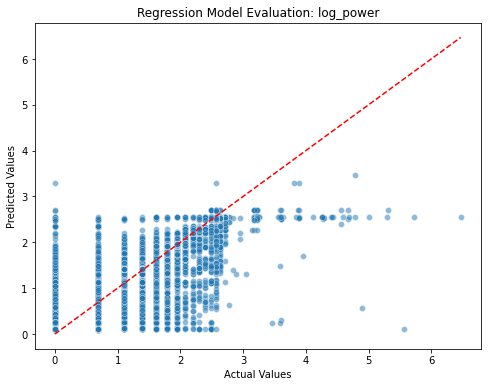

📊 RMSE: 0.6828, MAE: 0.1778, R²: 0.9300


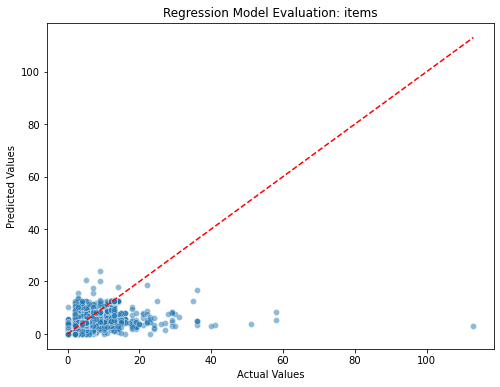

📊 Accuracy: 0.9866, F1-score: 0.9866


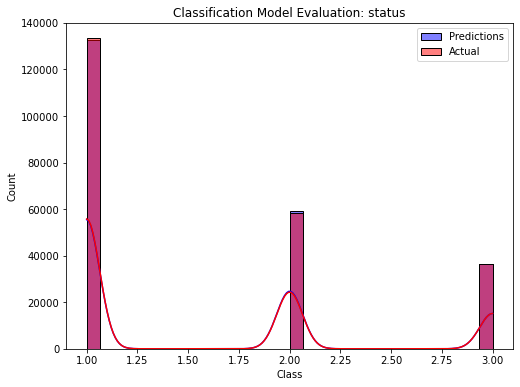

📊 RMSE: 0.2383, MAE: 0.1094, R²: 0.9748


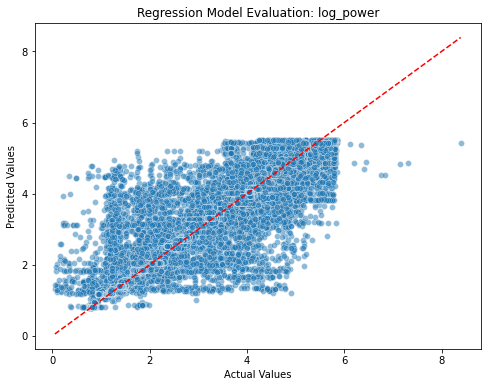

📊 Accuracy: 0.9568, F1-score: 0.9571


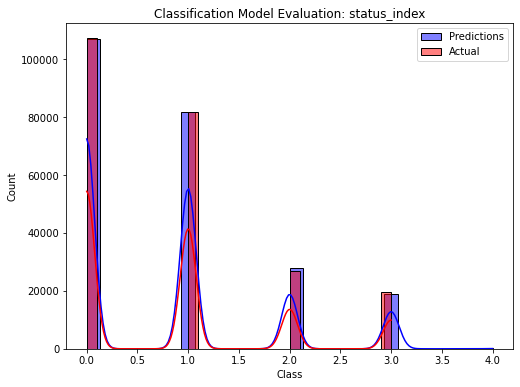

In [ ]:
# Run evaluation for all models
evaluator.evaluate_regression(evaluator.load_model("power_forecast_A").transform(test_A), "log_power")
evaluator.evaluate_regression(evaluator.load_model("product_count_forecast_A").transform(test_A), "items")
evaluator.evaluate_classification(evaluator.load_model("next_state_forecast_A").transform(test_A), "status")

evaluator.evaluate_regression(evaluator.load_model("power_forecast_B").transform(test_B), "log_power")
evaluator.evaluate_classification(evaluator.load_model("next_state_forecast_B").transform(test_B), "status_index")

Based on the plots and histograms, the MSE, R^2 and Accuracy of all the models have usable values for tested data. company A's power consumption forecasting has less usable than the others but enough to check on newly registered data.

## Cluster Evaluations and Histograms

In [ ]:
#Assemble and Scale configurations for clustering
test_A_cluster = evaluator.assemble4KMeans(test_A, models_config_A["item_classification"])
print(f"Test A Cluster Size: {test_A_cluster.count()}")
test_A_cluster.select("features").show()

test_B_cluster = evaluator.assemble4KMeans(test_B, models_config_B["item_classification"])
print(f"Test B Cluster Size: {test_B_cluster.count()}")
test_B_cluster.select("features").show()

PCA applied — resulting columns: ['asset', 'items', 'status', 'status_time', 'power_avg', 'cycle_time', 'alarm', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'items_lag1', 'items_lag2', 'items_lag3', 'status_lag1', 'status_lag2', 'status_lag3', 'features', 'scaled_features', 'pca_features']


Test A Cluster Size: 228049


+--------------------+
|            features|
+--------------------+
|(7,[1,2,6],[3.0,6...|
|(7,[1,2,6],[3.0,6...|
|[1.0,3.0,60.0,0.0...|
|[2.0,2.0,60.0,1.0...|
|[3.0,1.0,60.0,1.0...|
|[4.0,2.0,60.0,0.0...|
|[5.0,2.0,60.0,4.0...|
|[6.0,2.0,60.0,3.0...|
|[7.0,2.0,60.0,2.0...|
|[8.0,2.0,60.0,12....|
|(7,[1,2,6],[3.0,6...|
|[1.0,3.0,60.0,0.0...|
|[2.0,2.0,60.0,1.0...|
|(7,[0,1,2],[3.0,1...|
|[4.0,2.0,60.0,0.0...|
|[5.0,2.0,60.0,2.0...|
|[6.0,2.0,60.0,3.0...|
|[7.0,2.0,60.0,2.0...|
|[8.0,2.0,60.0,13....|
|[6.0,1.0,60.0,1.0...|
+--------------------+
only showing top 20 rows



PCA applied — resulting columns: ['asset', 'alarm_time', 'loading_time', 'tooling_time', 'maintenance_time', 'support_time', 'power_avg', 'power_min', 'power_max', 'status_index', 'year', 'month', 'day', 'hour', 'ts_unix', 'log_power', 'log_power_lag1', 'log_power_lag2', 'log_power_lag3', 'status_index_lag1', 'status_index_lag2', 'status_index_lag3', 'features', 'scaled_features', 'pca_features']


Test B Cluster Size: 235310


+--------------------+
|            features|
+--------------------+
|[0.0,3.0,17.0,0.0...|
|[1.0,3.0,60.0,0.0...|
|[2.0,3.0,60.0,0.0...|
|(6,[0,5],[3.0,225...|
|(6,[0,5],[4.0,37....|
|(6,[0,5],[6.0,25....|
|(6,[0,5],[7.0,62....|
|[8.0,1.0,0.0,0.0,...|
|[9.0,3.0,60.0,0.0...|
|[10.0,1.0,0.0,0.0...|
|[12.0,1.0,0.0,0.0...|
|(6,[0,5],[13.0,13...|
|(6,[0,5],[15.0,24...|
|[0.0,3.0,17.0,0.0...|
|[1.0,3.0,60.0,0.0...|
|[2.0,3.0,60.0,0.0...|
|(6,[0,5],[3.0,228...|
|(6,[0,5],[4.0,37....|
|(6,[0,5],[6.0,28....|
|(6,[0,5],[7.0,62....|
+--------------------+
only showing top 20 rows



In [ ]:
#Adjust Loaded Pipeline for Kmeans
predictions_A = evaluator.pipeline2KMeans(evaluator.load_model("item_classification_A")).transform(test_A_cluster)
predictions_B = evaluator.pipeline2KMeans(evaluator.load_model("item_classification_B")).transform(test_B_cluster)

✅ Number of clusters: 5
✅ Number of clusters: 7


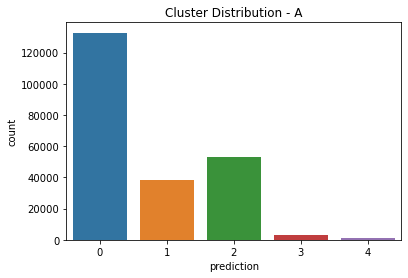

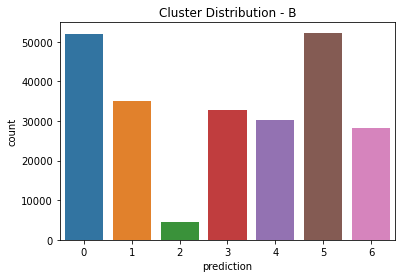

In [ ]:
sns.countplot(data=predictions_A.toPandas(), x="prediction")
plt.title("Cluster Distribution - A")
plt.show()
sns.countplot(data=predictions_B.toPandas(), x="prediction")
plt.title("Cluster Distribution - B")
plt.show()


### Evaluation after PCA on clusters

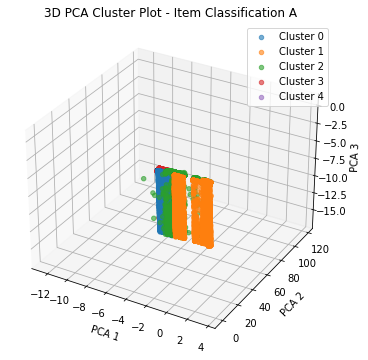

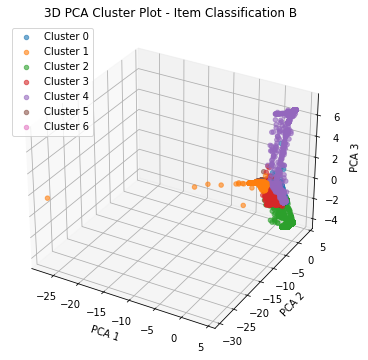

In [ ]:
# If PCA already applied
if "pca_features" in predictions_A.columns:
    evaluator.convert_PCA_Columns(predictions_A,"Item Classification A")
if "pca_features" in predictions_B.columns:
    evaluator.convert_PCA_Columns(predictions_B,"Item Classification B")


### Pseudo Labels Boosting Evaluation

2025-03-25 17:53:20,720 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-03-25 17:54:00,259 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-03-25 17:54:41,037 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


📊 XGBoost Unsupervised Evaluation:
RMSE: 3.0015, MAE: 2.3065, R²: -1.6851


2025-03-25 17:55:21,316 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


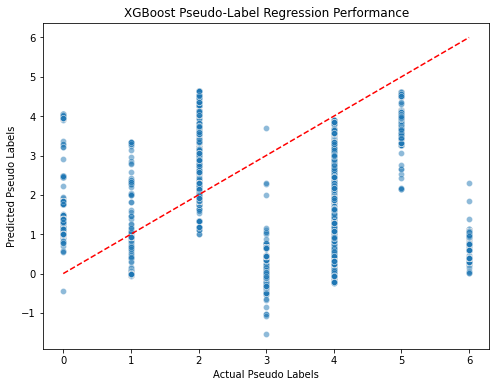

In [ ]:
test_B_cluster = test_B_cluster.repartition(200)

kmeans_model = KMeans(k=7, featuresCol="pca_features", predictionCol="pseudo_labels", distanceMeasure="cosine", seed=42)

test_B_boost = kmeans_model.fit(test_B_cluster).transform(test_B_cluster)

evaluator.evaluate_xgboost_unsupervised(evaluator.load_model("product_count_forecast_B").transform(test_B_boost))

Based on the plot, regression doesn't seem like the correct pipeline for pseudo-labeled data. negative R^2 indicates a bad fit to the data evaluated. Classification into value ranges might be a possible alternative for this pipeline.